#### TPUs:
- "Artificial Neural Networks based on the AI applications on the AI applications used to train the TPUs are 15 and 30 times faster that the CPUs and GPUS"

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd

# data input setcion
import os

# Data Visualisation
import cv2
import matplotlib.pyplot as plt
import seaborn as sns

# ELA
from PIL import Image, ImageChops

# Model Preparation
import random

# Model creation
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers

# Model evaluation
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# from sklearn.model_selection import StratifiedShuffleSplit
from pathlib import Path
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Splitting the data into train , validation and test for the model

#### Load ELA images as data input
- To create the validation set, we need to combine the train, and test data then split the data is such a way that it then creates a split for the validation set too. Recall we are now working with a different class of images. This section deals with the ELA images instead of the raw images

In [10]:
def create_classes(label): # I will use this method to define the 2 classes of classification needed for this task
    if label.startswith('AI'):
        return "AI"
    else:
        return "Human"

##### Extract from Train Data

In [2]:
training_data_path = Path('./Real_AI_SD_LD_Dataset/train')

# Get a list of all image paths with both .JPG and .jpg extensions
paths = list(training_data_path.glob('**/*.JPG')) + list(training_data_path.glob('**/*.jpg'))
# Extract labels from the directory names
labels = [p.parent.name for p in paths]

train_df = pd.DataFrame({
    'Filepath': [str(p) for p in paths],
    'Label': labels
})
train_df.head(2)

,Filepath,Label
0,Real_AI_SD_LD_Dataset\train\AI_LD\AI_LD_art_no...,AI_LD_art_nouveau
1,Real_AI_SD_LD_Dataset\train\AI_LD\AI_LD_art_no...,AI_LD_art_nouveau


In [3]:
n_duplicates = train_df.duplicated(subset='Filepath').sum()
train_df = train_df.drop_duplicates(subset='Filepath')
print(f"For the train set: there were {n_duplicates} duplicated records, meaning {train_df['Filepath'].nunique()} records, after dropping those, now we have {len(train_df)}")

For the train set: there were 155064 duplicated records, meaning 155064 records, after dropping those, now we have 155064


##### Extract from Test Data

In [4]:
testing_data_path = Path('./Real_AI_SD_LD_Dataset/test')

# Get a list of all image paths with both .JPG and .jpg extensions
paths = list(testing_data_path.glob('**/*.JPG')) + list(testing_data_path.glob('**/*.jpg'))
# Extract labels from the directory names
labels = [p.parent.name for p in paths]

test_df = pd.DataFrame({
    'Filepath': [str(p) for p in paths],
    'Label': labels
})
print(test_df.head(2))

                                            Filepath              Label
0  Real_AI_SD_LD_Dataset\test\AI_LD\AI_LD_art_nou...  AI_LD_art_nouveau
1  Real_AI_SD_LD_Dataset\test\AI_LD\AI_LD_art_nou...  AI_LD_art_nouveau


In [5]:
n_duplicates = test_df.duplicated(subset='Filepath').sum()
test_df = test_df.drop_duplicates(subset='Filepath')
print(f"For the train set: there were {n_duplicates} duplicated records, meaning {test_df['Filepath'].nunique()} records, after dropping those, now we have {len(test_df)}")

For the train set: there were 30000 duplicated records, meaning 30000 records, after dropping those, now we have 30000


In [6]:
train_df = train_df[~train_df['Label'].str.startswith('AI_SD_')]
len(train_df)

102141

In [7]:
test_df = test_df[~test_df['Label'].str.startswith('AI_SD_')]
len(test_df)

20000

#### Concated Data(Train + Test)

In [11]:
train_df['Label'] = train_df['Label'].apply(create_classes)
train_df['Label'].unique()

array(['AI', 'Human'], dtype=object)

In [12]:
test_df['Label'] = test_df['Label'].apply(create_classes)
test_df['Label'].unique()

array(['AI', 'Human'], dtype=object)

In [13]:
train_df.head(2)

,Filepath,Label
0,Real_AI_SD_LD_Dataset\train\AI_LD\AI_LD_art_no...,AI
1,Real_AI_SD_LD_Dataset\train\AI_LD\AI_LD_art_no...,AI


In [14]:
train_df.nunique()

Filepath    102141
Label            2
dtype: int64

I then create the dataframes for each the train, validation and test sets using an 80/10/10 split

In [15]:
data = train_df

In [16]:
train_df, validation_df = train_test_split(data, test_size=0.2, stratify=data['Label'], random_state=42)

In [17]:
test_df.nunique()

Filepath    20000
Label           2
dtype: int64

In [18]:
validation_df.nunique()

Filepath    20429
Label           2
dtype: int64

# DATA GENERATORS

In [19]:
batch_sze = 64
image_size = 256

In [20]:
# Define ImageDataGenerators for rescaling
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(image_size, image_size),
    batch_size=32,
    shuffle=True,
    class_mode='categorical' # I use 'categorical' if I have multiple classes, but binary would do still(not sparse)
)

validation_generator = val_datagen.flow_from_dataframe(
    dataframe=validation_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(image_size, image_size),
    batch_size=32,
    shuffle=False,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(image_size, image_size),
    batch_size=32,
    shuffle=False,
    class_mode='categorical'
)

Found 81712 validated image filenames belonging to 2 classes.
Found 20429 validated image filenames belonging to 2 classes.
Found 20000 validated image filenames belonging to 2 classes.


# MODEL BUILDING

In [21]:
model = models.Sequential([
    layers.Conv2D(32, (3,3), activation = 'relu', input_shape = (image_size, image_size, 3)),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(128, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(256, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    
    layers.Flatten(),
    layers.Dense(512, activation =  'relu'),
    layers.Dense(2, activation = 'softmax'), 
    
    #layers.Dropout(0.5),
    ])

C:\Users\phall\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


# MODEL TRAINING

In [22]:
model.compile(loss = 'categorical_crossentropy'
            #,optimizer = optimizers.RMSprop(learning_rate = 0.001),
            ,optimizer = optimizers.Adam(learning_rate = 0.001),
            metrics=['acc', 'binary_accuracy'],
            )

In [ ]:
"""from keras.callbacks import ModelCheckpoint, EarlyStopping
model_checkpoint1 = ModelCheckpoint('./{epoch:02d}-{acc:.2f}.keras', monitor='val_loss', save_best_only=True, mode='min', verbose=1)
model_checkpoint2 = EarlyStopping(monitor="val_loss", patience=2)"""

'from keras.callbacks import ModelCheckpoint, EarlyStopping\nmodel_checkpoint1 = ModelCheckpoint(\'./{epoch:02d}-{acc:.2f}.keras\', monitor=\'val_loss\', save_best_only=True, mode=\'min\', verbose=1)\nmodel_checkpoint2 = EarlyStopping(monitor="val_loss", patience=2)'

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 15, 15, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     6,423,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │         1,026 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,812,482 (25.99 MB)

 Trainable params: 6,812,482 (25.99 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Fit the model with early stopping
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_df) // batch_sze,  # Batch size
    epochs=20,
    validation_data=validation_generator,
    validation_steps=len(validation_generator) // batch_sze,
    #callbacks=[early_stopping]  # Add the EarlyStopping callback
    #callbacks=[model_checkpoint1, model_checkpoint2]
)

Epoch 1/20


C:\Users\phall\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1276/1276 ━━━━━━━━━━━━━━━━━━━━ 1363s 1s/step - acc: 0.7561 - binary_accuracy: 0.7561 - loss: 0.4847 - val_acc: 0.8993 - val_binary_accuracy: 0.8993 - val_loss: 0.2577
Epoch 2/20
1276/1276 ━━━━━━━━━━━━━━━━━━━━ 771s 604ms/step - acc: 0.8940 - binary_accuracy: 0.8940 - loss: 0.2585 - val_acc: 0.9167 - val_binary_accuracy: 0.9167 - val_loss: 0.2395
Epoch 3/20
   2/1276 ━━━━━━━━━━━━━━━━━━━━ 6:58 328ms/step - acc: 0.9453 - binary_accuracy: 0.9453 - loss: 0.1520

C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.9_3.9.3568.0_x64__qbz5n2kfra8p0\lib\contextlib.py:137: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


1276/1276 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - acc: 0.9531 - binary_accuracy: 0.9531 - loss: 0.1306 - val_acc: 0.8785 - val_binary_accuracy: 0.8785 - val_loss: 0.2572
Epoch 4/20
1276/1276 ━━━━━━━━━━━━━━━━━━━━ 471s 366ms/step - acc: 0.9176 - binary_accuracy: 0.9176 - loss: 0.2024 - val_acc: 0.9410 - val_binary_accuracy: 0.9410 - val_loss: 0.1659
Epoch 5/20
1276/1276 ━━━━━━━━━━━━━━━━━━━━ 405s 317ms/step - acc: 0.9378 - binary_accuracy: 0.9378 - loss: 0.1615 - val_acc: 0.9340 - val_binary_accuracy: 0.9340 - val_loss: 0.1542
Epoch 6/20
1276/1276 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - acc: 0.9062 - binary_accuracy: 0.9062 - loss: 0.2559 - val_acc: 0.9340 - val_binary_accuracy: 0.9340 - val_loss: 0.1910
Epoch 7/20
1276/1276 ━━━━━━━━━━━━━━━━━━━━ 401s 314ms/step - acc: 0.9470 - binary_accuracy: 0.9470 - loss: 0.1369 - val_acc: 0.9340 - val_binary_accuracy: 0.9340 - val_loss: 0.1635
Epoch 8/20
1276/1276 ━━━━━━━━━━━━━━━━━━━━ 398s 312ms/step - acc: 0.9576 - binary_accuracy: 0.9576 - loss: 0.1123 - val

In [ ]:
len(history.history['loss'])

20

# MODEL EVALUATION

# Evaluate the model on the test set
loss, accuracy = model.evaluate(test_generator, steps=len(test_generator))

print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")


In [28]:
predictions = model.predict(test_generator, steps=len(test_generator))
predicted_classes = np.argmax(predictions, axis=1)
true_labels = test_generator.classes

625/625 ━━━━━━━━━━━━━━━━━━━━ 416s 667ms/step


In [29]:
# Compute classification report
report = classification_report(true_labels, predicted_classes, target_names=test_generator.class_indices.keys())
print(report)

              precision    recall  f1-score   support

          AI       0.89      0.96      0.92     10000
       Human       0.95      0.88      0.92     10000

    accuracy                           0.92     20000
   macro avg       0.92      0.92      0.92     20000
weighted avg       0.92      0.92      0.92     20000



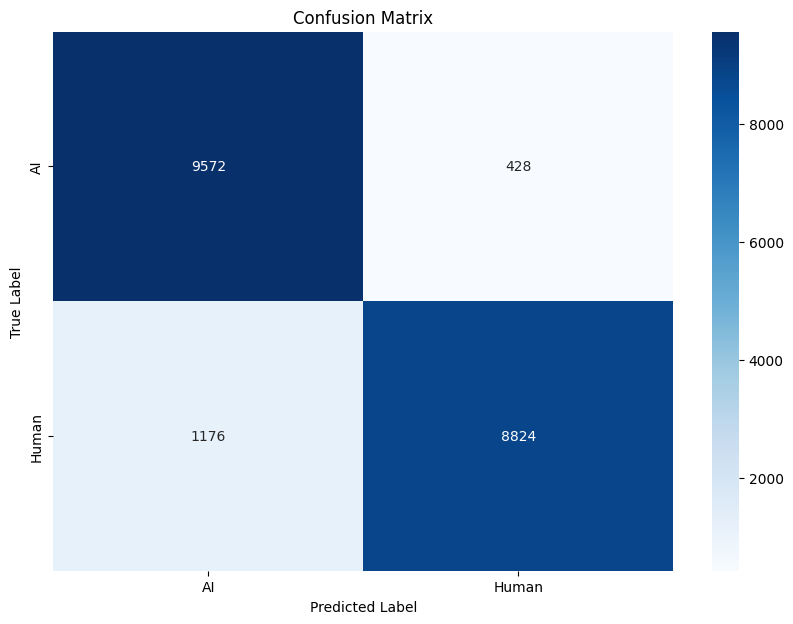

In [30]:
# Compute confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_classes)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=test_generator.class_indices.keys(), 
            yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [31]:
epochs = history.epoch
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['acc']  
val_acc = history.history['val_acc'] 
train_binary_acc = history.history['binary_accuracy']
val_binary_acc = history.history['val_binary_accuracy']

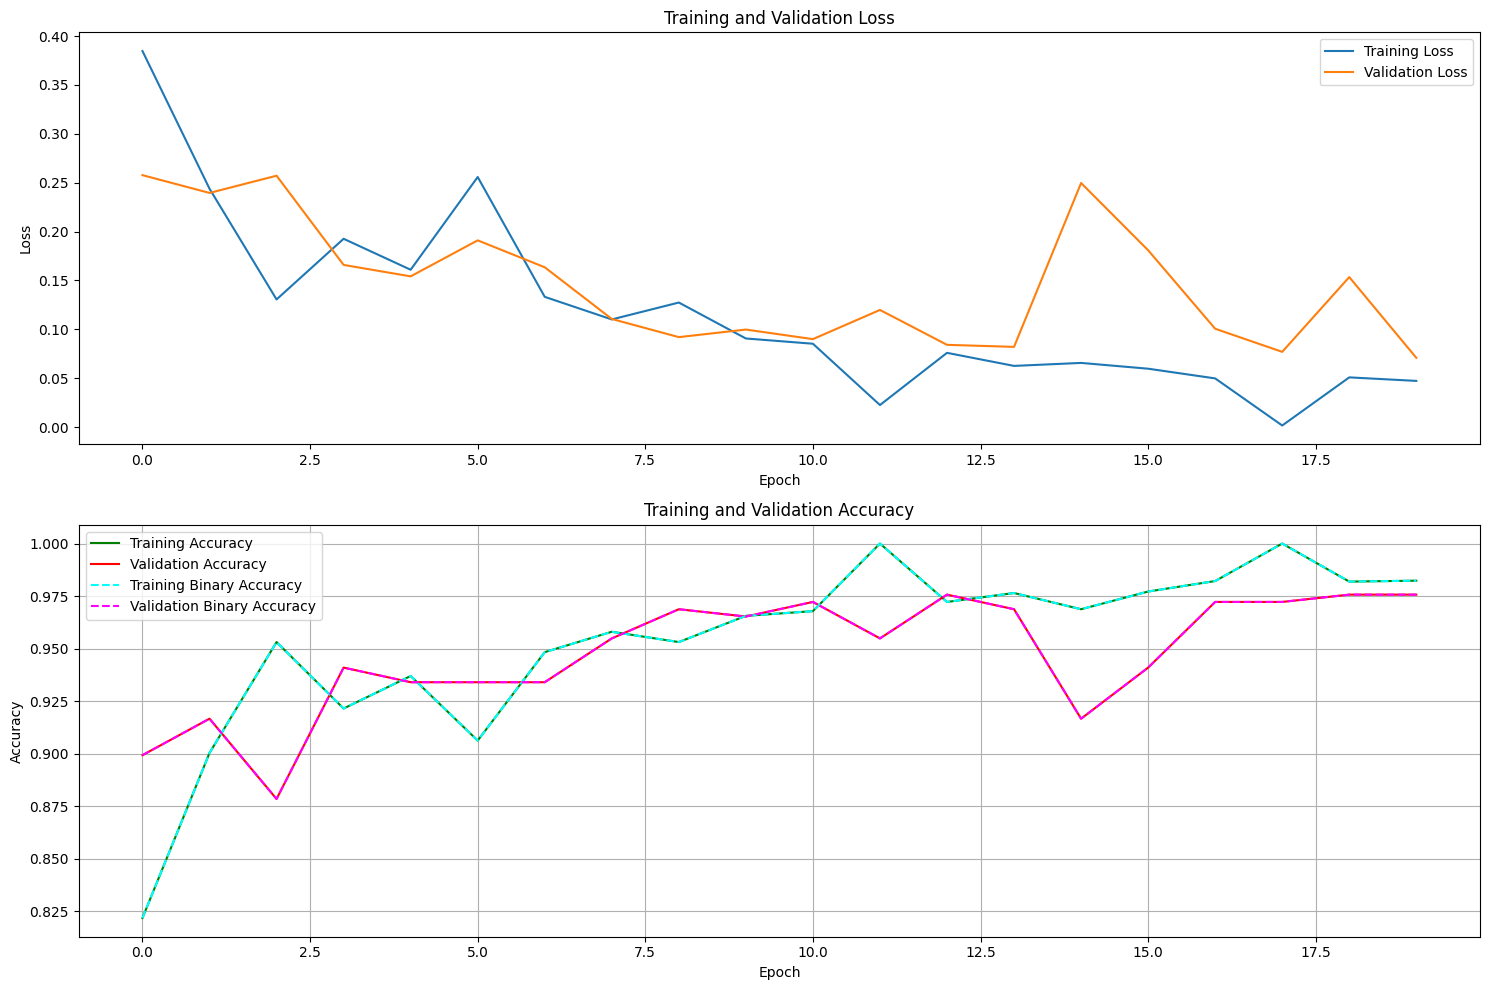

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(15, 10))

# Plot training and validation loss
axs[0].plot(epochs, train_loss, label='Training Loss')
axs[0].plot(epochs, val_loss, label='Validation Loss')
axs[0].set_title('Training and Validation Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()

axs[1].plot(epochs, train_acc, label='Training Accuracy', color='green')
axs[1].plot(epochs, val_acc, label='Validation Accuracy', color='red')
axs[1].plot(epochs, train_binary_acc, label='Training Binary Accuracy', linestyle='--', color='cyan')
axs[1].plot(epochs, val_binary_acc, label='Validation Binary Accuracy', linestyle='--', color='magenta')
axs[1].set_title('Training and Validation Accuracy')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
axs[1].legend()
axs[1].grid()

# Adjusting layout
plt.tight_layout()
plt.show()

# References

- https://python-graph-gallery.com/10-barplot-with-number-of-observation/
- https://matplotlib.org/3.3.4/gallery/statistics/barchart_demo.html#sphx-glr-gallery-statistics-barchart-demo-py
- https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.text.html
- https://www.quora.com/Why-does-OpenCV-interpret-image-data-using-BGR-instead-of-RGB
- https://datacarpentry.org/image-processing/02-image-basics.html
- https://www.kaggle.com/code/nibrastuhh/ai-artbench-ai-vs-human-art-detection-90-acc
-https://datacarpentry.org/image-processing/05-creating-histograms.html
- https://www.linkedin.com/pulse/some-tricks-handling-imbalanced-dataset-image-m-farhan-tandia
- https://medium.com/@maahip1304/the-complete-guide-to-image-preprocessing-techniques-in-python-dca30804550c

- - Handling missing/imbalanced data: https://www.analyticsvidhya.com/blog/2021/06/5-techniques-to-handle-imbalanced-data-for-a-classification-problem/
- - - **Use F1-Score to judge/evaluate model on imbalanced data**
- https://medium.com/@mohitjavali/10-ways-to-extract-features-from-an-image-f44c8e9b0fbf
- https://github.com/skj092/Forgegy-Image-Detection-Using-Error-level-Analysis-and-Deep-Learning